In [74]:
import os
import cv2
import torch
from torch.nn import ReLU
from torch.nn import Conv2d
from torch.nn import Module
from torch.optim import Adam
from torch.nn import MaxPool2d
from torch.nn import ModuleList
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop
from PIL import Image
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
file_list_train = sorted(os.listdir('/content/gdrive/MyDrive/training_set'))
len(file_list_train)

1998

In [19]:
file_list_test = sorted(os.listdir('/content/gdrive/MyDrive/test_set'))
file_list_test[0:6]

['100_HC.png',
 '101_HC.png',
 '102_2HC.png',
 '103_HC.png',
 '104_HC.png',
 '105_3HC.png']

In [40]:
train_image = []
train_mask = []
for idx, item in enumerate(file_list_train):
    if idx % 2 == 0:
        train_image.append('/content/gdrive/MyDrive/training_set/{i}'.format(i = item))
    else:
        train_mask.append('/content/gdrive/MyDrive/training_set/{i}'.format(i = item))
print("Number of US images is {}".format(len(train_image)))
print("Number of US masks is {}".format(len(train_mask)))  
print(train_image[:10],"\n" ,train_mask[:10])

Number of US images is 999
Number of US masks is 999
['/content/gdrive/MyDrive/training_set/100_2HC.png', '/content/gdrive/MyDrive/training_set/101_HC.png', '/content/gdrive/MyDrive/training_set/102_2HC.png', '/content/gdrive/MyDrive/training_set/103_HC.png', '/content/gdrive/MyDrive/training_set/104_HC.png', '/content/gdrive/MyDrive/training_set/105_HC.png', '/content/gdrive/MyDrive/training_set/106_HC.png', '/content/gdrive/MyDrive/training_set/107_HC.png', '/content/gdrive/MyDrive/training_set/108_2HC.png', '/content/gdrive/MyDrive/training_set/109_HC.png'] 
 ['/content/gdrive/MyDrive/training_set/100_2HC_Annotation.png', '/content/gdrive/MyDrive/training_set/101_HC_Annotation.png', '/content/gdrive/MyDrive/training_set/102_2HC_Annotation.png', '/content/gdrive/MyDrive/training_set/103_HC_Annotation.png', '/content/gdrive/MyDrive/training_set/104_HC_Annotation.png', '/content/gdrive/MyDrive/training_set/105_HC_Annotation.png', '/content/gdrive/MyDrive/training_set/106_HC_Annotation.

(540, 800)


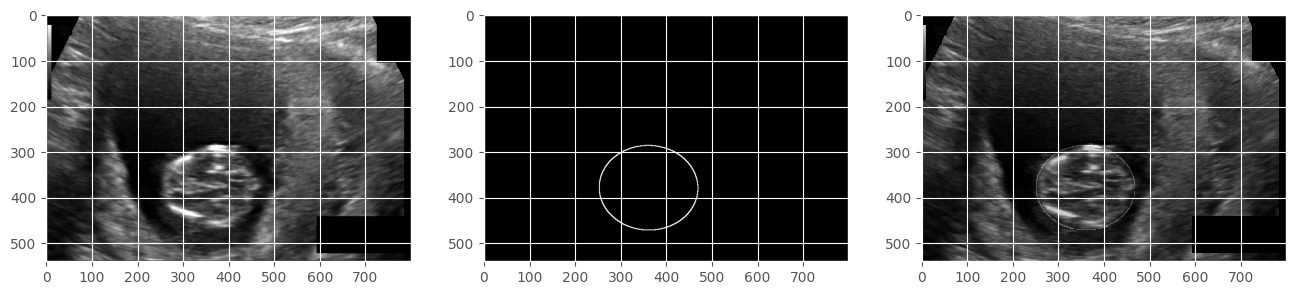

In [78]:
image1 = np.array(Image.open("/content/gdrive/MyDrive/training_set/"+"100_2HC.png"))
image1_mask = np.array(Image.open("/content/gdrive/MyDrive/training_set/"+"100_2HC_Annotation.png"))

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'gray', interpolation = 'none', alpha = 0.2)
print(image1.shape)

In [21]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [65]:
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

INIT_LR = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 64

INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

THRESHOLD = 0.5

In [8]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
        
	def __len__(self):
		
		return len(self.imagePaths)
    
	def __getitem__(self, idx):
		
		imagePath = self.imagePaths[idx]
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
        
		if self.transforms is not None:
			
			image = self.transforms(image)
			mask = self.transforms(mask)
            
		
		return (image, mask)

In [9]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
        
	def forward(self, x):
		
		return self.conv2(self.relu(self.conv1(x)))

In [10]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		
		self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
        
	def forward(self, x):
		blockOutputs = []
        
		for block in self.encBlocks:
			
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
            
		return blockOutputs

In [11]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
        
		self.channels = channels
  
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
  
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        
	def forward(self, x, encFeatures):
		for i in range(len(self.channels) - 1):

			x = self.upconvs[i](x)
          
			encFeat = self.crop(encFeatures[i], x)
      
			x = torch.cat([x, encFeat], dim=1)
      
			x = self.dec_blocks[i](x)
            
		return x
    
	def crop(self, encFeatures, x):
		
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
        
		return encFeatures

In [12]:
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
		
	def forward(self, x):
		
		encFeatures = self.encoder(x)
		
		decFeatures = self.decoder(encFeatures[::-1][0],encFeatures[::-1][1:])
		
		map_ = self.head(decFeatures)
		
		if self.retainDim:
			map_ = F.interpolate(map_, self.outSize)
			
		return map_

In [83]:
imagePaths = sorted(train_image)
maskPaths = sorted(train_mask)

trainImages, testImages,trainMasks, testMasks = train_test_split(imagePaths, maskPaths, test_size=0.15, random_state=42)

testMasks

['/content/gdrive/MyDrive/training_set/509_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/815_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/28_2HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/37_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/768_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/621_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/907_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/592_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/494_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/711_2HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/943_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/673_2HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/881_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/644_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/74_HC_Annotation.png',
 '/content/gdrive/MyDrive/training_set/164_HC_Annotatio

In [70]:
import torchvision

MEMORY = True if DEVICE == "cuda" else False
transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)), torchvision.transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms)

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,	batch_size=BATCH_SIZE, pin_memory=MEMORY, num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False, batch_size=BATCH_SIZE, pin_memory=MEMORY, num_workers=os.cpu_count())
trainLoader

In [45]:
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

In [49]:
H = {"train_loss": [], "test_loss": []}

for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
    
	
	totalTrainLoss = 0
	totalTestLoss = 0
    
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
        
		
		pred = unet(x)
		loss = lossFunc(pred, y)
        
		opt.zero_grad()
		loss.backward()
		opt.step()
        
		
		totalTrainLoss += loss
        

	with torch.no_grad():
		
		unet.eval()
        
		for (x, y) in testLoader:
			
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
            
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
            
	
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
    
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))

  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    i

[INFO] EPOCH: 1/10
Train loss: 0.071404, Test loss: 0.0696


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[INFO] EPOCH: 2/10
Train loss: 0.052700, Test loss: 0.0695


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[INFO] EPOCH: 3/10
Train loss: 0.048658, Test loss: 0.0651


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[INFO] EPOCH: 4/10
Train loss: 0.046965, Test loss: 0.0635


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e10641940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[INFO] EPOCH: 5/10
Train loss: 0.046484, Test loss: 0.0633


 60%|██████    | 6/10 [07:09<04:45, 71.34s/it]

[INFO] EPOCH: 6/10
Train loss: 0.046290, Test loss: 0.0632


 70%|███████   | 7/10 [08:18<03:32, 70.67s/it]

[INFO] EPOCH: 7/10
Train loss: 0.046198, Test loss: 0.0631


 80%|████████  | 8/10 [09:30<02:22, 71.03s/it]

[INFO] EPOCH: 8/10
Train loss: 0.046242, Test loss: 0.0630


 90%|█████████ | 9/10 [10:40<01:10, 70.62s/it]

[INFO] EPOCH: 9/10
Train loss: 0.046247, Test loss: 0.0629


100%|██████████| 10/10 [11:59<00:00, 71.90s/it]

[INFO] EPOCH: 10/10
Train loss: 0.046044, Test loss: 0.0629


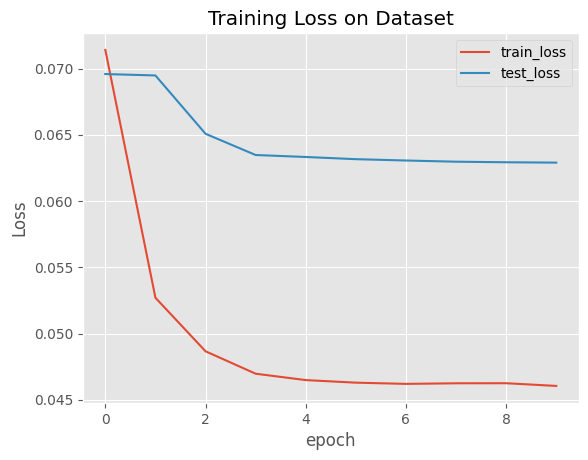

In [85]:
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [63]:
def plot(origImage, predMask):

	figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
	ax[0].imshow(origImage)
	ax[1].imshow(predMask)

	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")

	figure.show()

In [68]:
def make_predictions(model, imagePath):
	
	model.eval()

	with torch.no_grad():
		
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0

		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
        
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)

		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()

		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)

		# prepare a plot for visualization
		plot(orig, predMask)

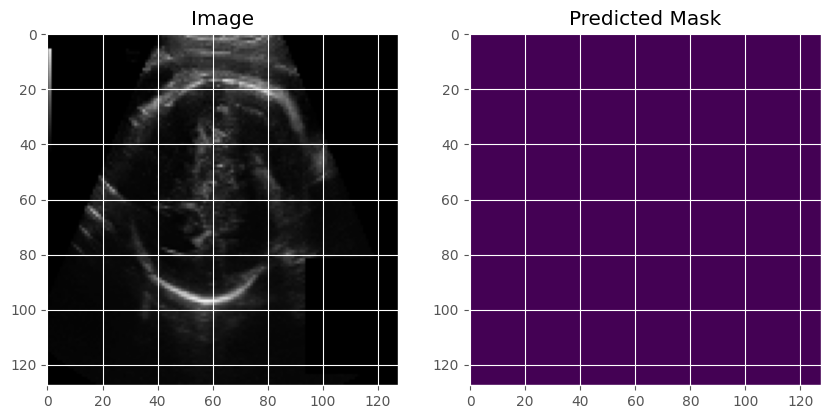

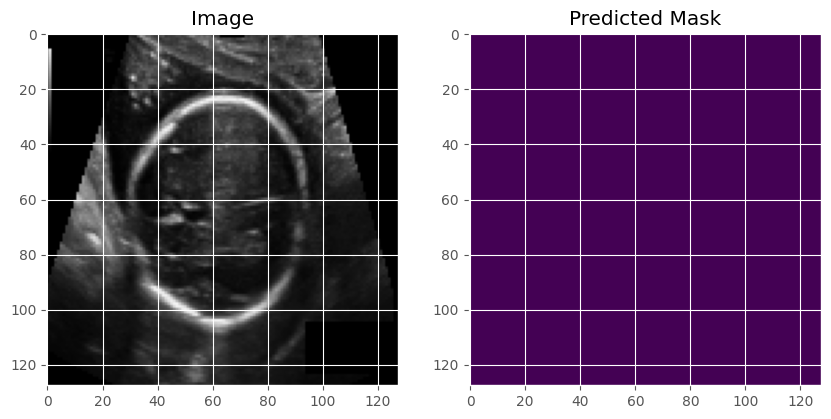

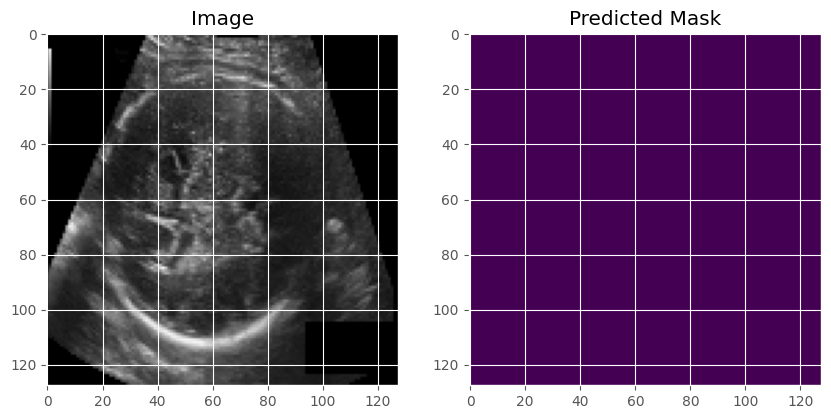

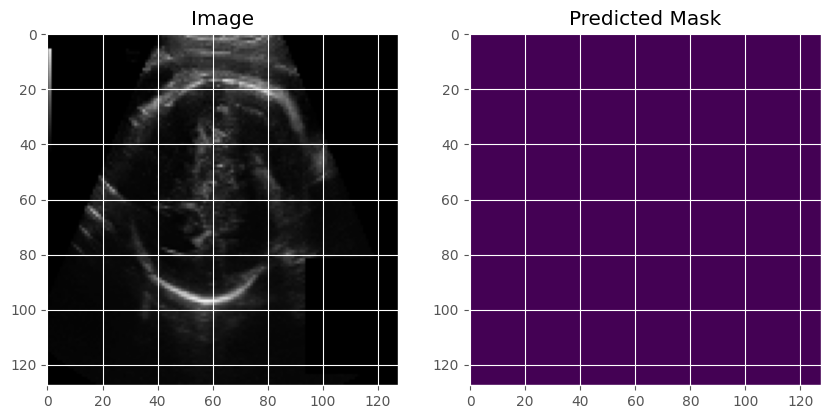

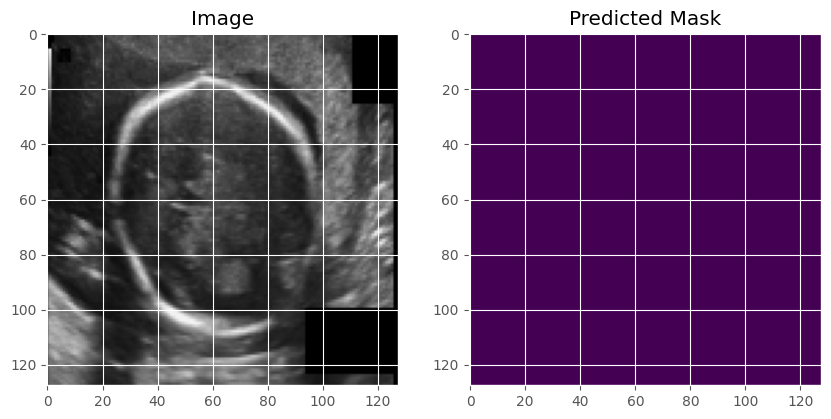

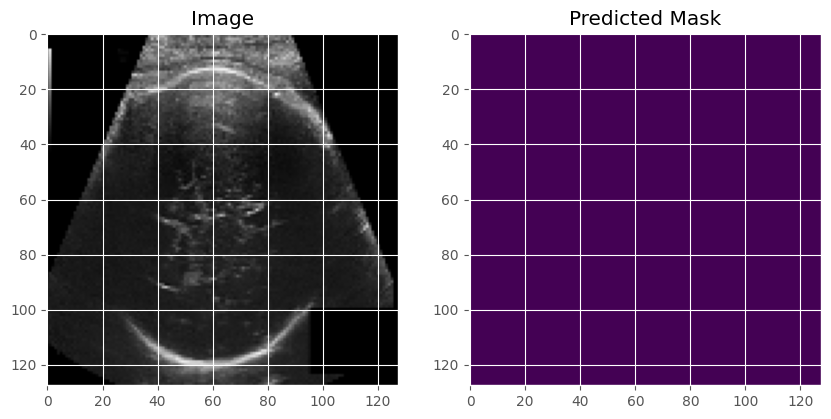

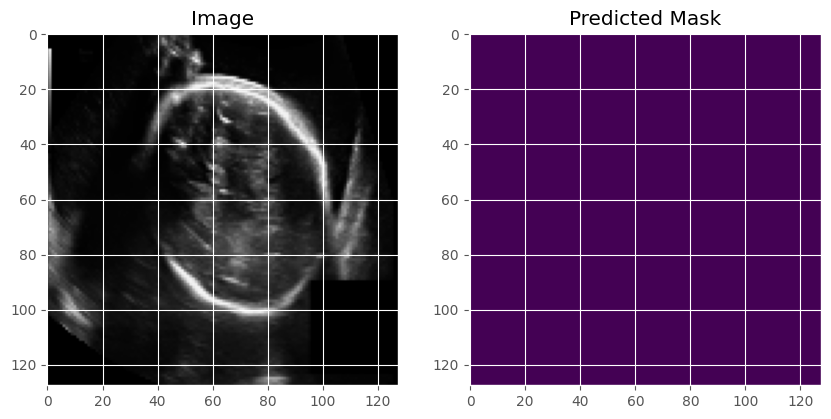

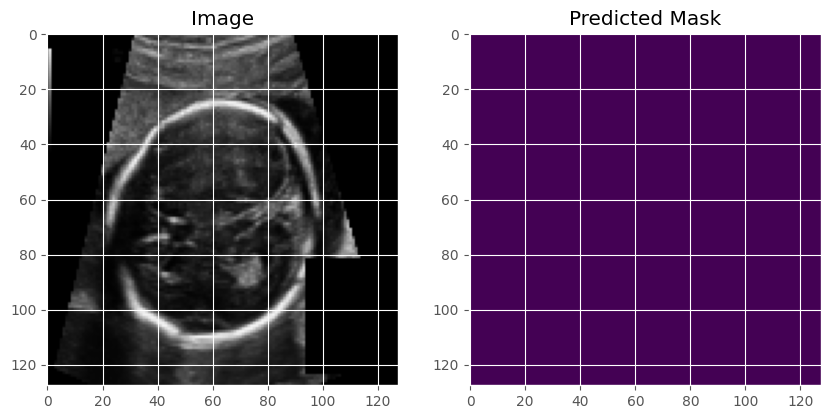

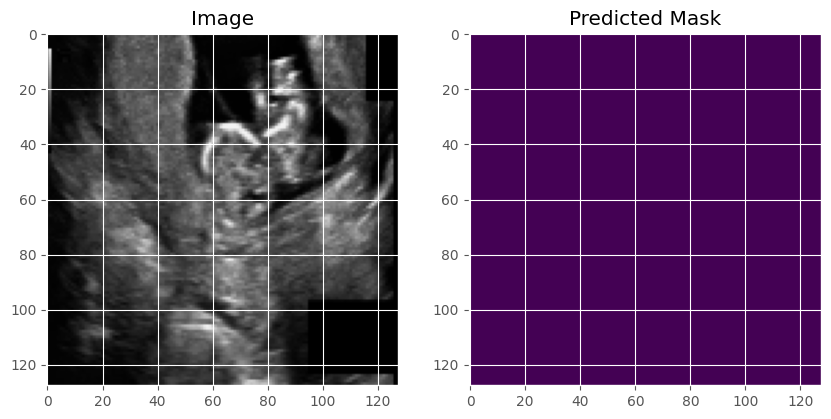

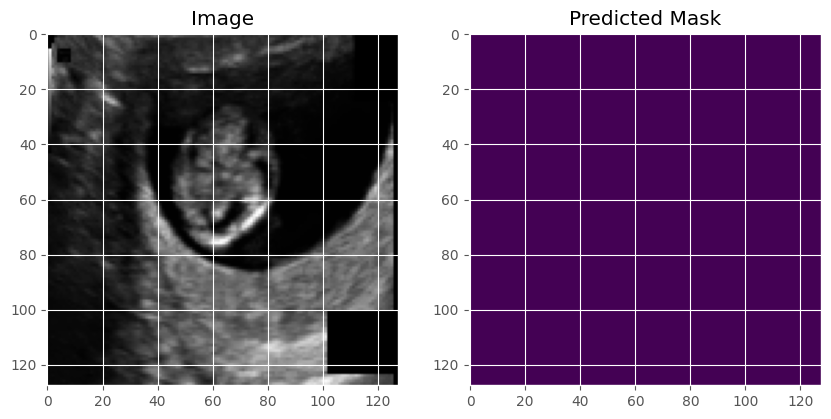

In [72]:
import numpy as np

imagePaths = testImages
imagePaths = np.random.choice(imagePaths, size=10)

# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)